In [1]:
import mircxpol as mp
from scipy.optimize import curve_fit


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import Angle, SkyCoord, EarthLocation, AltAz
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from IPython.display import display, HTML
import pandas as pd 

In [3]:
path_csv = "2022Oct19_W1S1.csv"
# time = np.arange(4.5, 12.01, 0.01) * u.hour
time = np.linspace(4.5, 12.01, 378) * u.hour
upsand = SkyCoord.from_name("ups and")
ptime = Time("2022-10-19 0:00:00") + time 

df = pd.read_csv(path_csv)
MJD_data = df['MJD'].values
MJD_data = MJD_data.reshape(-1, 1)
HA_data = df['HA'].values
HA_data = HA_data.reshape(-1, 1)
VisRatio_data = df['VisRatio'].values
VisRatio_data = VisRatio_data.reshape(-1, 1)
PD_data = df['PhaseDiff'].values
PD_data = PD_data.reshape(-1, 1)
HA = Angle(time).value

chara = EarthLocation.of_site("CHARA")
upsandaltaz = upsand.transform_to(AltAz(obstime=ptime, location=chara))
alt = upsandaltaz.alt
az = upsandaltaz.az
# Find the index of the maximum altitude
zenith_idx = np.argmax(alt)
zenith_time = HA[zenith_idx]
HA = HA - zenith_time

In [4]:
# def func1(HA, r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12): #, Q12, U12, V12, Qii, Uii, Vii): #, p, q):
def func1(HA, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82):#, I12): #, p, q):

    r_m31, c_m31, r_m41, c_m41, r_m81, c_m81 = 1., 0., 1., 0., 1., 0.
    Q12, U12, V12, Qii, Uii, Vii = 0., 0., 0., 0., 0., 0.
    I12 = 1.
    
    C11 = mp.C(1, Qii, Uii, Vii)
    C22 = mp.C(1, Qii, Uii, Vii)
    C12 = mp.C(I12, Q12, U12, V12)

    V_amplitude = np.zeros((len(time), 3))
    V_phase = np.zeros((len(time), 3))
    VR = np.zeros((len(time), 3))
    DP = np.zeros((len(time), 3))

    for i in range(len(time)):
        alt_i = alt[i].value
        az_i = az[i].value

        J1_i = mp.Jall(alt_i, az_i, r_m31, c_m31, r_m41, c_m41, r_m81, c_m81)
        J2_i = mp.Jall(alt_i, az_i, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82)

        V_amplitude[i][0] = abs(mp.Vis(J1_i, J2_i, C12, C11, C22, 0)[0]) #Vis_total
        V_amplitude[i][1] = abs(mp.Vis(J1_i, J2_i, C12, C11, C22, 1)[0]) #Vis_HH
        V_amplitude[i][2] = abs(mp.Vis(J1_i, J2_i, C12, C11, C22, 2)[0]) #Vis_VV

        V_phase[i][0] = mp.Vis(J1_i, J2_i, C12, C11, C22, 0)[1]
        V_phase[i][1] = mp.Vis(J1_i, J2_i, C12, C11, C22, 1)[1]
        V_phase[i][2] = mp.Vis(J1_i, J2_i, C12, C11, C22, 2)[1]

        VR[i][0] = abs(mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[0]) #VH
        VR[i][1] = abs(mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[1]) #VV
        VR[i][2] = abs(mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[1])/ abs(mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[0])  #VV/VH

        DP[i][0] = mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[2]#PH
        DP[i][1] = mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[3] #PV
        DP[i][2] = mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[3] - mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[2]


    V_total = V_amplitude[:, 0]
    V_H = V_amplitude[:, 1]
    V_V = V_amplitude[:, 2]

    V_total_phase = V_phase[:, 0]
    V_H_phase = V_phase[:, 1] 
    V_V_phase = V_phase[:, 2] 

    V_H1 = VR[:, 0]
    V_V1 = VR[:, 1]
    V_Ratio = VR[:, 2]
    V_H_phase1 = DP[:, 0] 
    V_V_phase1 = DP[:, 1]
    D_phase = DP[:, 2]
    
    return V_Ratio

In [5]:
# def func2(HA, r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12): #, Q12, U12, V12, Qii, Uii, Vii): #, p, q):
def func2(HA, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82):#, I12): #, p, q):

    r_m31, c_m31, r_m41, c_m41, r_m81, c_m81 = 1., 0., 1., 0., 1., 0.
    Q12, U12, V12, Qii, Uii, Vii = 0., 0., 0., 0., 0., 0.
    I12 = 1.
    
    C11 = mp.C(1, Qii, Uii, Vii)
    C22 = mp.C(1, Qii, Uii, Vii)
    C12 = mp.C(I12, Q12, U12, V12)

    V_amplitude = np.zeros((len(time), 3))
    V_phase = np.zeros((len(time), 3))
    VR = np.zeros((len(time), 3))
    DP = np.zeros((len(time), 3))

    for i in range(len(time)):
        alt_i = alt[i].value
        az_i = az[i].value

        J1_i = mp.Jall(alt_i, az_i, r_m31, c_m31, r_m41, c_m41, r_m81, c_m81)
        J2_i = mp.Jall(alt_i, az_i, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82)

        V_amplitude[i][0] = abs(mp.Vis(J1_i, J2_i, C12, C11, C22, 0)[0]) #Vis_total
        V_amplitude[i][1] = abs(mp.Vis(J1_i, J2_i, C12, C11, C22, 1)[0]) #Vis_HH
        V_amplitude[i][2] = abs(mp.Vis(J1_i, J2_i, C12, C11, C22, 2)[0]) #Vis_VV

        V_phase[i][0] = mp.Vis(J1_i, J2_i, C12, C11, C22, 0)[1]
        V_phase[i][1] = mp.Vis(J1_i, J2_i, C12, C11, C22, 1)[1]
        V_phase[i][2] = mp.Vis(J1_i, J2_i, C12, C11, C22, 2)[1]

        VR[i][0] = abs(mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[0]) #VH
        VR[i][1] = abs(mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[1]) #VV
        VR[i][2] = abs(mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[1])/ abs(mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[0])  #VV/VH

        DP[i][0] = mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[2]#PH
        DP[i][1] = mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[3] #PV
        DP[i][2] = mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[3] - mp.Vis_diff(J1_i, J2_i, C12, C11, C22)[2]


    V_total = V_amplitude[:, 0]
    V_H = V_amplitude[:, 1]
    V_V = V_amplitude[:, 2]

    V_total_phase = V_phase[:, 0]
    V_H_phase = V_phase[:, 1] 
    V_V_phase = V_phase[:, 2] 

    V_H1 = VR[:, 0]
    V_V1 = VR[:, 1]
    V_Ratio = VR[:, 2]
    V_H_phase1 = DP[:, 0] 
    V_V_phase1 = DP[:, 1]
    D_phase = DP[:, 2]

    return D_phase

In [6]:
# def hr(HA, r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12):
#   fr = func1(HA, r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12)
#   gr = func2(HA, r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12)
#   return np.hstack((fr, gr))
# def hr(HA, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12):
#   fr = func1(HA, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12)
#   gr = func2(HA, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12)
#   return np.hstack((fr, gr))
def hr(HA, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82):
  fr = func1(HA, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82)
  gr = func2(HA, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82)
  return np.hstack((fr, gr))

In [7]:
hdata = np.hstack((VisRatio_data.flatten(), PD_data.flatten())) # (756,)
xdata = np.hstack((HA_data.flatten(), HA_data.flatten())) # (756,)

### test:

In [8]:
# popt, pcov = curve_fit(hr, xdata, hdata, bounds=([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0. ], [np.inf, 2., np.inf, 2., np.inf, 2., np.inf, 2., np.inf, 2., np.inf, 2., 1.]))
# popt
popt, pcov = curve_fit(hr, xdata, hdata, p0 = np.array([0.952, 0., 0.887, 0., 0.495, 1.778]), bounds=([0., 0., 0., 0., 0., 0.], [np.inf, 2., np.inf, 2., np.inf, 2.]))
popt

array([1.00669111e+00, 1.61833241e-20, 8.70673253e-01, 4.58931712e-23,
       4.80557232e-01, 1.77194437e+00])

Text(0.5, 0, 'Hour Angle')

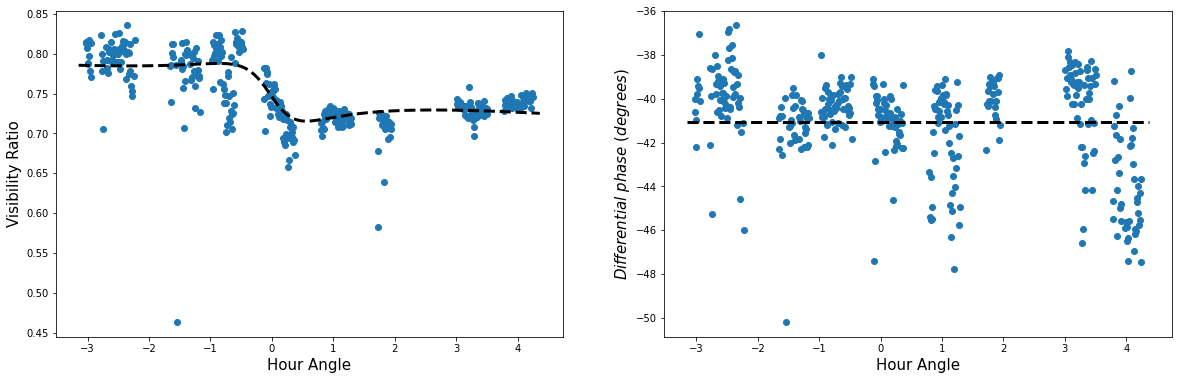

In [9]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(HA.flatten(), func1(HA.flatten(), *popt), linewidth=3, color='black', linestyle='--')
plt.scatter(HA_data, VisRatio_data)
plt.ylabel("Visibility Ratio", fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(HA.flatten(), func2(HA.flatten(), *popt), linewidth=3, color='black', linestyle='--')
plt.scatter(HA_data, PD_data)
plt.ylabel(r'$Differential~phase~(degrees)$', fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)

In [10]:
np.linalg.cond(pcov)

9214369.775614377

In [11]:
np.diag(pcov)

array([8.25314389e-01, 2.06778578e-06, 4.93230911e-01, 1.56990309e-06,
       2.23563205e-02, 3.48504365e-07])

In [12]:
popt_ = np.array([0.952, 0., 0.887, 0., 0.495, 1.778])
print(np.sum((VisRatio_data - func1(HA.flatten(), *popt_))**2))
print(np.sum((PD_data - func2(HA.flatten(), *popt_))**2))
print(np.sum((PD_data - func2(HA.flatten(), *popt_))**2) + np.sum((VisRatio_data - func1(HA.flatten(), *popt_))**2))

429.1175880629389
820841.8060294128
821270.9236174757


In [13]:
print(np.sum((VisRatio_data - func1(HA.flatten(), *popt))**2))
print(np.sum((PD_data - func2(HA.flatten(), *popt))**2))
print(np.sum((PD_data - func2(HA.flatten(), *popt))**2) + np.sum((VisRatio_data - func1(HA.flatten(), *popt))**2))

365.92918302832334
651076.95818933
651442.8873723582


In [105]:
popt1, pcov1 = curve_fit(hr, xdata, hdata, p0 = ([1.00669111e+00, 1.61833241e-20, 8.70673253e-01, 4.58931712e-23,
       4.80557232e-01, 1.77194437e+00]), bounds=([0., 0., 0., 0., 0., 0.], [np.inf, 2., np.inf, 2., np.inf, 2.]))
popt1

array([1.00672123e+00, 9.04335428e-17, 8.70650444e-01, 1.36206566e-17,
       4.80553918e-01, 1.77194437e+00])

Text(0.5, 0, 'Hour Angle')

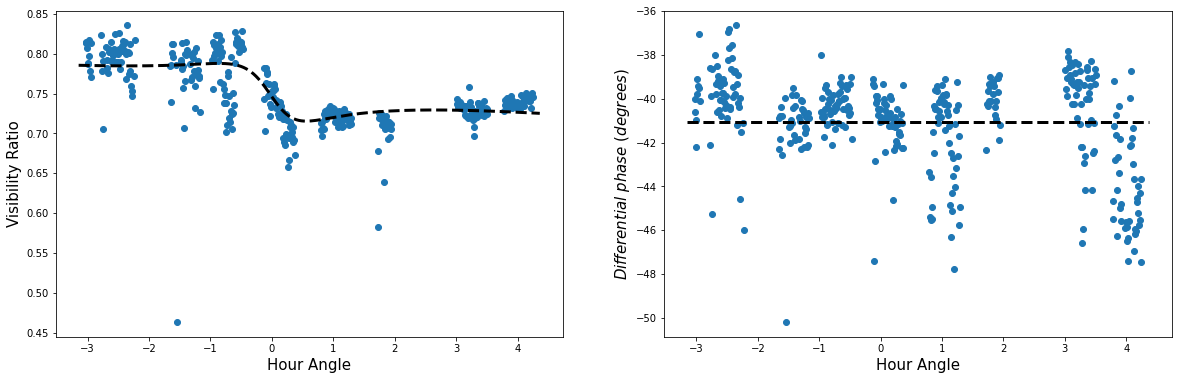

In [106]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(HA.flatten(), func1(HA.flatten(), *popt1), linewidth=3, color='black', linestyle='--')
plt.scatter(HA_data, VisRatio_data)
plt.ylabel("Visibility Ratio", fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(HA.flatten(), func2(HA.flatten(), *popt1), linewidth=3, color='black', linestyle='--')
plt.scatter(HA_data, PD_data)
plt.ylabel(r'$Differential~phase~(degrees)$', fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)

In [107]:
np.linalg.cond(pcov1)

9214275.117125992

In [108]:
np.diag(pcov)

array([8.25314389e-01, 2.06778578e-06, 4.93230911e-01, 1.56990309e-06,
       2.23563205e-02, 3.48504365e-07])

In [109]:
popt2, pcov2 = curve_fit(hr, xdata, hdata, p0 = ([8.25314389e-01, 2.06778578e-06, 4.93230911e-01, 1.56990309e-06,
       2.23563205e-02, 3.48504365e-07]), bounds=([0., 0., 0., 0., 0., 0.], [np.inf, 2., np.inf, 2., np.inf, 2.]))
print(popt2)
print(np.linalg.cond(pcov2))

[1.00845462e+00 1.32321702e-26 8.69030869e-01 2.01236553e-25
 4.80397088e-01 5.40393799e-29]
9199108.627196385


[1.19072133 0.00492416 1.02043524 1.99368867 1.9591793  1.77281797]
the condition number of the covariance matrix: 4631598.882946577


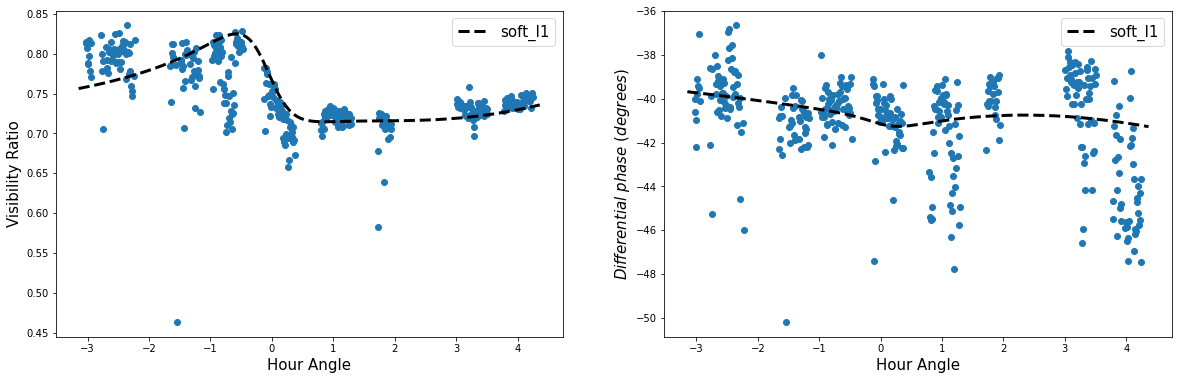

In [120]:
popt3, pcov3 = curve_fit(hr, xdata, hdata, loss='soft_l1', bounds=([0., 0., 0., 0., 0., 0.], [np.inf, 2., np.inf, 2., np.inf, 2.]))
print(popt3)
print("the condition number of the covariance matrix:", np.linalg.cond(pcov3))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(HA.flatten(), func1(HA.flatten(), *popt3), linewidth=3, color='black', linestyle='--', label = 'soft_l1')
plt.scatter(HA_data, VisRatio_data)
plt.ylabel("Visibility Ratio", fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(HA.flatten(), func2(HA.flatten(), *popt3), linewidth=3, color='black', linestyle='--', label = 'soft_l1')
plt.scatter(HA_data, PD_data)
plt.ylabel(r'$Differential~phase~(degrees)$', fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

[1.05473297 2.         1.09661503 1.99784426 2.04394119 1.77429059]
the condition number of the covariance matrix: 5334123.333205141


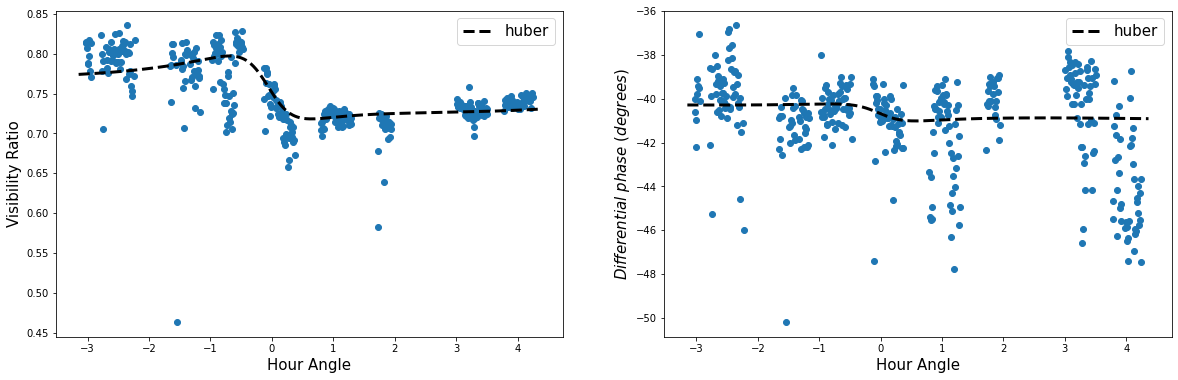

In [121]:
popt3, pcov3 = curve_fit(hr, xdata, hdata, loss='huber', bounds=([0., 0., 0., 0., 0., 0.], [np.inf, 2., np.inf, 2., np.inf, 2.]))
print(popt3)
print("the condition number of the covariance matrix:", np.linalg.cond(pcov3))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(HA.flatten(), func1(HA.flatten(), *popt3), linewidth=3, color='black', linestyle='--', label = 'huber')
plt.scatter(HA_data, VisRatio_data)
plt.ylabel("Visibility Ratio", fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(HA.flatten(), func2(HA.flatten(), *popt3), linewidth=3, color='black', linestyle='--', label = 'huber')
plt.scatter(HA_data, PD_data)
plt.ylabel(r'$Differential~phase~(degrees)$', fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

[0.98917281 2.         1.14948395 1.99884022 2.0787079  1.77525058]
the condition number of the covariance matrix: 2990102.418053817


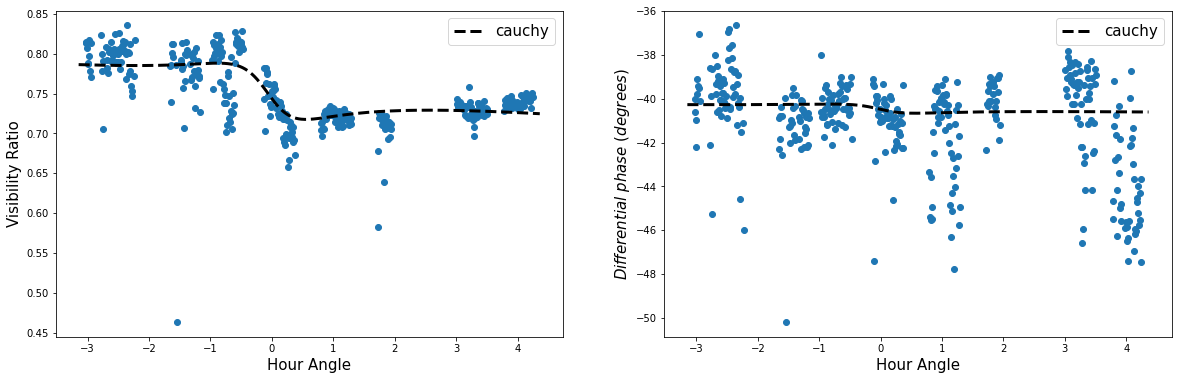

In [122]:
popt3, pcov3 = curve_fit(hr, xdata, hdata, loss='cauchy', bounds=([0., 0., 0., 0., 0., 0.], [np.inf, 2., np.inf, 2., np.inf, 2.]))
print(popt3)
print("the condition number of the covariance matrix:", np.linalg.cond(pcov3))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(HA.flatten(), func1(HA.flatten(), *popt3), linewidth=3, color='black', linestyle='--', label = 'cauchy')
plt.scatter(HA_data, VisRatio_data)
plt.ylabel("Visibility Ratio", fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(HA.flatten(), func2(HA.flatten(), *popt3), linewidth=3, color='black', linestyle='--', label = 'cauchy')
plt.scatter(HA_data, PD_data)
plt.ylabel(r'$Differential~phase~(degrees)$', fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

[0.97755457 1.99209807 1.02249925 1.00886334 2.19337841 0.77204532]
the condition number of the covariance matrix: 2745958.2046373608


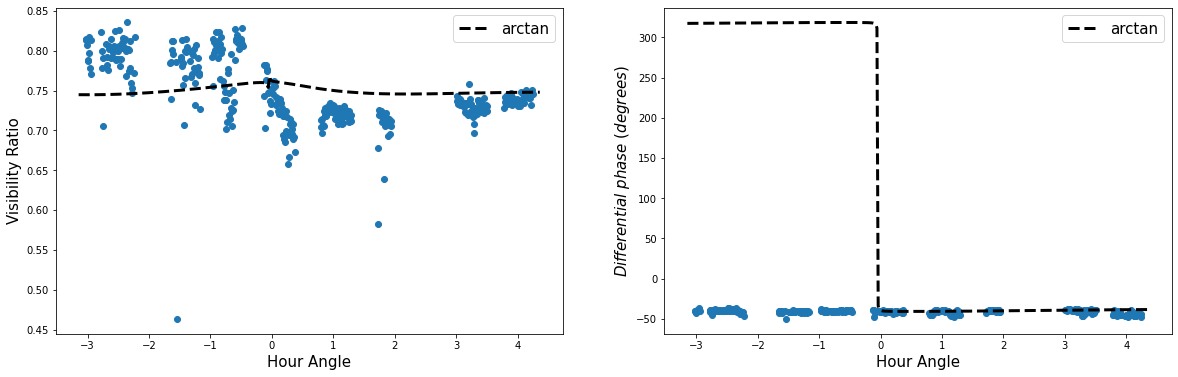

In [123]:
popt3, pcov3 = curve_fit(hr, xdata, hdata, loss='arctan', bounds=([0., 0., 0., 0., 0., 0.], [np.inf, 2., np.inf, 2., np.inf, 2.]))
print(popt3)
print("the condition number of the covariance matrix:", np.linalg.cond(pcov3))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(HA.flatten(), func1(HA.flatten(), *popt3), linewidth=3, color='black', linestyle='--', label = 'arctan')
plt.scatter(HA_data, VisRatio_data)
plt.ylabel("Visibility Ratio", fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

plt.subplot(1, 2, 2)
plt.plot(HA.flatten(), func2(HA.flatten(), *popt3), linewidth=3, color='black', linestyle='--', label = 'arctan')
plt.scatter(HA_data, PD_data)
plt.ylabel(r'$Differential~phase~(degrees)$', fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

### check:

429.1175880629389
820841.8060294128
821270.9236174757


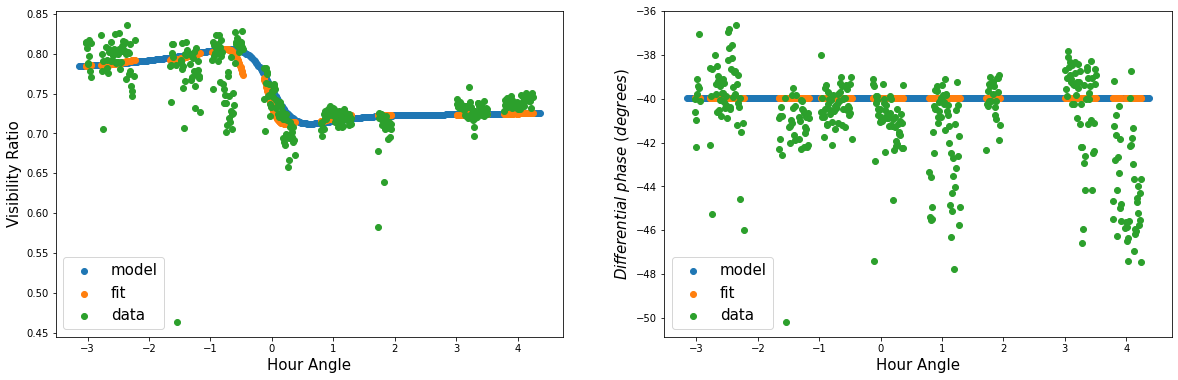

In [103]:
popt_ = np.array([0.952, 0., 0.887, 0., 0.495, 1.778])#, 1.]) # 1., 0., 1., 0., 1., 0., 
print(np.sum((VisRatio_data - func1(HA_data.flatten(), *popt_))**2))
print(np.sum((PD_data - func2(HA_data.flatten(), *popt_))**2))
print(np.sum((PD_data - func2(HA_data.flatten(), *popt_))**2) + np.sum((VisRatio_data - func1(HA_data.flatten(), *popt_))**2))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.scatter(HA.flatten(), func1(HA.flatten(), *popt_), label='model')#, linewidth=3, color='black', linestyle='--')
plt.scatter(HA_data.flatten(), func1(HA_data.flatten(), *popt_), label='fit')
plt.scatter(HA_data, VisRatio_data, label='data')
plt.ylabel("Visibility Ratio", fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

plt.subplot(1, 2, 2)
plt.scatter(HA.flatten(), func2(HA.flatten(), *popt_), label='model')#, linewidth=3, color='black', linestyle='--')
plt.scatter(HA_data.flatten(), func2(HA_data.flatten(), *popt_), label='fit')
plt.scatter(HA_data, PD_data, label='data')
plt.ylabel(r'$Differential~phase~(degrees)$', fontsize = 15)
plt.xlabel("Hour Angle", fontsize = 15)
plt.legend(fontsize = 15)

In [104]:
print(np.sum((VisRatio_data - func1(HA.flatten(), *popt_))**2))
print(np.sum((PD_data - func2(HA.flatten(), *popt_))**2))
print(np.sum((PD_data - func2(HA.flatten(), *popt_))**2) + np.sum((VisRatio_data - func1(HA.flatten(), *popt_))**2))

429.1175880629389
820841.8060294128
821270.9236174757


### test:

In [ ]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + y_noise

plt.plot(xdata, ydata, 'b-', label='data')

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
plt.plot(xdata, func(xdata, *popt), 'g--')


def func2(x, a, b, c, d):
    return a * d * np.exp(-b * x) + c  # a and d are redundant
popt2, pcov2 = curve_fit(func2, xdata, ydata)

plt.plot(xdata, func2(xdata, *popt2), 'r--')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
np.diag(pcov)

In [ ]:
np.diag(pcov2)

In [ ]:
np.linalg.cond(pcov2)

In [ ]:
np.diag(pcov2)

In [ ]:
# Get the RSS (Residual Sum of Squares)
residuals2 = hdata - hr(xdata, *popt2)
RSS = np.sum(residuals2**2)

# Estimate the standard deviation of the residuals
residual_std2 = np.std(residuals2)

# Compute the likelihood assuming residuals follow a normal distribution
logL = np.sum(np.log(1 / (np.sqrt(2 * np.pi) * residual_std2) * 
                    np.exp(-0.5 * (residuals2 / residual_std2)**2)))
# Calculate BIC
n_params = len(popt2)
N = len(xdata)
BIC = n_params * np.log(N) - 2 * logL

print("BIC:", BIC)

In [ ]:
logL

In [ ]:
popt1, pcov1 = curve_fit(func1, HA_data.flatten(), VisRatio_data.flatten(), bounds=([-np.inf, 0, -np.inf, 0, -np.inf, 0, 0. ], [np.inf, 2., np.inf, 2., np.inf, 2., 1.]))
popt1

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(HA_data.flatten(), func1(HA_data.flatten(), *popt1), linewidth=3, color='black', linestyle='--')
# plt.plot(HA_data.flatten(), func2(HA_data.flatten(), *popt1), linewidth=3, color='blue', linestyle='--')
plt.scatter(HA_data, VisRatio_data)
# plt.scatter(HA_data, PD_data)

In [ ]:
# Get the RSS (Residual Sum of Squares)
residuals1 = HA_data.flatten() - func1(HA_data.flatten(), *popt1).flatten()
RSS = np.sum(residuals1**2)

# Estimate the standard deviation of the residuals
residual_std1 = np.std(residuals1)

# Compute the likelihood assuming residuals follow a normal distribution
logL = np.sum(np.log(1 / (np.sqrt(2 * np.pi) * residual_std1) * 
                    np.exp(-0.5 * (residuals1 / residual_std1)**2)))
# Calculate BIC
n_params = len(popt1)
N1 = len(HA_data)
BIC = n_params * np.log(N1) - 2 * logL

print("BIC:", BIC)

In [ ]:
# initial = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0]
# r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii = initial

# V_H = func((alt, az), r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii, 1, 1)
# V_H_phase = func((alt, az), r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii, 1, 2)
# V_V = func((alt, az), r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii, 2, 1)
# V_V_phase = func((alt, az), r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii, 2, 2)
# V_total = func((alt, az), r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii, 3, 1)
# V_total_phase = func((alt, az), r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii, 3, 2)
# V_Ratio = func((alt, az), r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii, 4, 1)
# D_phase = func((alt, az), r_m31, c_m31, r_m41, c_m41, r_m81, c_m81, r_m32, c_m32, r_m42, c_m42, r_m82, c_m82, I12, Q12, U12, V12, Qii, Uii, Vii, 4, 2)
# V_R = func(HA, 1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0)
# plt.plot(HA, V_R, '-')
# plt.scatter(HA_data, VisRatio_data)

# popt, pcov = curve_fit(func, HA_data.flatten(), VisRatio_data.flatten(), bounds=([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, ], [1., 2., 1., 2.,1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., ]))
# popt, pcov = curve_fit(func, HA_data.flatten(), VisRatio_data.flatten(), bounds=([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, ], [1., 2., 1., 2.,1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., ]))
# popt

# plt.figure(figsize=(12, 8))
# plt.plot(HA_data.flatten(), func(HA_data.flatten(), *popt), linewidth=3, color='black', linestyle='--')
# plt.scatter(HA_data, VisRatio_data)

# np.linalg.cond(pcov)
# np.diag(pcov)
# popt
# HA_data.reshape(1, -1)

In [ ]:

# plt.figure(figsize=(20, 12))
# plt.subplot(2, 2, 3)
# plt.axvline(x = HA[zenith_idx], color='green', linestyle='--', label='zenith')
# plt.plot(HA, V_total, label="Total", linewidth=3, color='black', linestyle='--')
# plt.plot(HA, V_H, label="Horizontal")
# plt.plot(HA, V_V, label="Vertical")
# # plt.title(sys.argv[2] + ', ' + sys.argv[3], fontsize = 15)
# plt.ylabel("Visibility", fontsize = 15)
# plt.xlabel("Hour Angle", fontsize = 15)
# plt.grid()
# plt.legend(fontsize = 15)

# plt.subplot(2, 2, 4)
# plt.axvline(x = HA[zenith_idx], color='green', linestyle='--', label='zenith')
# plt.plot(HA, V_total_phase, label="Total", linewidth=3, color='black', linestyle='--')
# plt.plot(HA, V_H_phase, label="Horizontal")
# plt.plot(HA, V_V_phase, label="Vertical")
# plt.ylabel(r'$Phase (degree)$', fontsize = 15)
# plt.xlabel("Hour Angle", fontsize = 15)
# plt.grid()
# plt.legend(fontsize = 15)


# plt.subplot(2, 2, 1)
# plt.axvline(x = HA[zenith_idx], color='green', linestyle='--', label='zenith')
# plt.plot(HA, V_Ratio, label="Ratio", linewidth=3, color='black', linestyle='--')

# plt.scatter(HA_data, VisRatio_data)#, label="W1-S1")
# # plt.title(sys.argv[2] + ', ' + sys.argv[3], fontsize = 15)
# plt.ylabel("Visibility Ratio", fontsize = 15)
# plt.xlabel("Hour Angle", fontsize = 15)
# plt.grid()
# plt.legend(fontsize = 15)

# plt.subplot(2, 2, 2)
# plt.plot(HA, D_phase, label="Diff", linewidth=3, color='black', linestyle='--')
# plt.scatter(HA_data, PD_data)#, label="W1-S1")
# plt.axvline(x = HA[zenith_idx], color='green', linestyle='--', label='zenith')
# plt.ylabel(r'$Differential~phase~(degrees)$', fontsize = 15)
# plt.xlabel("Hour Angle", fontsize = 15)
# plt.grid()
# plt.legend(fontsize = 15)

# plt.tight_layout()
# plt.show()

In [ ]:
# def main():

#     r_m31_widget = FloatSlider(min=0.100, max=1.000, step=0.001, value=1.000, description="M1-3", readout_format='.3f')
#     c_m31_widget = FloatSlider(min=0.000, max=2.000, step=0.001, value=0.000, description="Phase M1-3", readout_format='.3f')
#     r_m41_widget = FloatSlider(min=0.100, max=1.000, step=0.001, value=1.000, description = "M4-7", readout_format='.3f')
#     c_m41_widget = FloatSlider(min=0.000, max=2.000, step=0.001, value=0.000, description = "Phase M4-7", readout_format='.3f')
#     r_m81_widget = FloatSlider(min=0.100, max=1.000, step=0.001, value=1.000, description = "M8-19", readout_format='.3f')
#     c_m81_widget = FloatSlider(min=0.000, max=2.000, step=0.001, value=0.000, description = "Phase M8-19", readout_format='.3f')

#     r_m32_widget = FloatSlider(min=0.100, max=1.000, step=0.001, value=1.000, description = "M1-3", readout_format='.3f')
#     c_m32_widget = FloatSlider(min=0.000, max=2.000, step=0.001, value=0.000, description = "Phase M1-3", readout_format='.3f')
#     r_m42_widget = FloatSlider(min=0.100, max=1.000, step=0.001, value=1.000, description = "M4-7", readout_format='.3f')
#     c_m42_widget = FloatSlider(min=0.000, max=2.000, step=0.001, value=0.000, description = "Phase M4-7", readout_format='.3f')
#     r_m82_widget = FloatSlider(min=0.100, max=1.000, step=0.001, value=1.000, description = "M8-19", readout_format='.3f')
#     c_m82_widget = FloatSlider(min=0.000, max=2.000, step=0.001, value=0.000, description = "Phase M8-19", readout_format='.3f')

#     I12_widget = FloatSlider(min=0.000, max=1.000, step=0.001, value=1.00, description = "I12", readout_format='.3f')
#     Q12_widget = FloatSlider(min=-1.000, max=1.000, step=0.001, value=0.00, description = "Q12", readout_format='.3f')
#     U12_widget = FloatSlider(min=-1.000, max=1.000, step=0.001, value=0.00, description = "U12", readout_format='.3f')
#     V12_widget = FloatSlider(min=-1.000, max=1.000, step=0.001, value=0.00, description = "V12", readout_format='.3f')

#     # Iii_widget = FloatSlider(min=0.000, max=1.000, step=0.001, value=1.00, description = "Iii", readout_format='.3f')
#     Qii_widget = FloatSlider(min=-1.000, max=1.000, step=0.001, value=0.00, description = "Qii", readout_format='.3f')
#     Uii_widget = FloatSlider(min=-1.000, max=1.000, step=0.001, value=0.00, description = "Uii", readout_format='.3f')
#     Vii_widget = FloatSlider(min=-1.000, max=1.000, step=0.001, value=0.00, description = "Vii", readout_format='.3f')

#     left_title = widgets.HTML(value="<div style='text-align: center;'><h3>beam1</h3></div>")
#     center_title = widgets.HTML(value="<div style='text-align: center;'><h3>beam2</h3></div>")
#     right_title = widgets.HTML(value="<div style='text-align: center;'><h3>Stokes parameters</h3></div>")

#     left_box = widgets.VBox([left_title, r_m31_widget, c_m31_widget, r_m41_widget, c_m41_widget, r_m81_widget, c_m81_widget])
#     center_box = widgets.VBox([center_title, r_m32_widget, c_m32_widget, r_m42_widget, c_m42_widget, r_m82_widget, c_m82_widget])
#     right_box = widgets.VBox([right_title, I12_widget, Q12_widget, U12_widget, V12_widget, Qii_widget, Uii_widget, Vii_widget]) # Iii_widget,
#     all_widgets = widgets.HBox([left_box, center_box, right_box])

#     out = widgets.interactive_output(plot_func, {'r_m31': r_m31_widget, 'c_m31': c_m31_widget, 'r_m41': r_m41_widget, 
#                                                 'c_m41': c_m41_widget, 'r_m81': r_m81_widget, 'c_m81': c_m81_widget, 
#                                                 'r_m32': r_m32_widget, 'c_m32': c_m32_widget, 'r_m42': r_m42_widget, 
#                                                 'c_m42': c_m42_widget, 'r_m82': r_m82_widget, 'c_m82': c_m82_widget,
#                                                 'I12': I12_widget, 'Q12': Q12_widget, 'U12': U12_widget, 'V12': V12_widget, 
#                                                 'Qii': Qii_widget, 'Uii': Uii_widget, 'Vii': Vii_widget})  # 'Iii': Iii_widget


#     if I12_widget.value +Q12_widget.value > 1 - Qii_widget.value:
#         print(f"I12 + Q12 is not within the expected range")

#     elif I12_widget.value - Q12_widget.value > 1 - Qii_widget.value:
#         print(f"I12 - Q12 is not within the expected range")

#     css = """
#     .bg-red {
#         background-color: rgba(255, 0, 0, 0.25) !important; /* Adjust the last value (0.5) to change the transparency */
#     }

#     """

#     # Create an HTML widget to apply CSS
#     html = widgets.HTML(value="<style>{}</style>".format(css))

#     # Function to update widget background color based on condition
#     def update_color(change):
#         if I12_widget.value +Q12_widget.value > 1 - Qii_widget.value:
#             all_widgets.add_class("bg-red")
#         elif I12_widget.value - Q12_widget.value > 1 - Qii_widget.value:
#             all_widgets.add_class("bg-red")
#         else:
#             all_widgets.remove_class("bg-red")

#     # Link widget value change to color update function
#     I12_widget.observe(update_color, names='value')
#     Q12_widget.observe(update_color, names='value')
#     Qii_widget.observe(update_color, names='value')

#     display(html)
#     display(all_widgets, out)


# if __name__ == "__main__":
#     main()